<a href="https://colab.research.google.com/github/bielperello/Node21_AA_2025-26/blob/modelsClas2/Node21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecte Node21: Classificació i Detecció de Nòduls Pulmonars en Radiografies de Pit.

In [ ]:
'''
from google.colab import drive
import os

# 1. Connectar Drive
drive.mount('/content/drive')

# 2. Descomprimir el ZIP (ajusta la ruta si el nom de la carpeta al Drive és diferent)
# El posem a /content/ perquè la lectura des del disc local del Colab és molt més ràpida que des del Drive directe
!unzip "/content/drive/MyDrive/Projecte_Node21/colab_data.zip" -d "/content/dataset_reduit"

# 3. Instal·lar la llibreria per llegir imatges mèdiques
!pip install SimpleITK

# Instal·lar la llibreria OpenCV
!pip install opencv-python
'''

## Introducció
En aquest projecte abordarem la detecció de nòduls pulmonars en radiografies de tòrax (CXR) seguint l'enunciat del repte **Node21** ([enllaç al repte](https://node21.grand-challenge.org/)). El repte Node21 proporciona un conjunt de dades públic de radiografies frontals de pit amb nòduls pulmonars anotats mitjançant **caixes delimitadores** (bounding boxes). En total consta d'aproximadament **4.882 radiografies**, de les quals **1.134** contenen almenys un nòdul i **3.748** imatges no en contenen, actuant com a casos negatius.  

L'objectiu consisteix en aplicar tècniques d'aprenentatge automàtic al problema proposat. S'han definit un **conjunt de tasques seqüencials** per tal de facilitar-ne el desenvolupament:

1. **Classificació**: Desenvolupar un sistema de classificació binària capaç de determinar si una radiografia conté nòduls pulmonars. Aquesta tasca es resoldrà mitjançant l'avaluació de **quatre models diferents**, alguns d'entrenats des de zero i d'altres aprofitant tècniques de *transfer learning*.
2. **Detecció**: Implementar models de detecció per localitzar els nòduls en la imatge, identificant-ne la posició amb caixes delimitadores. Per aquesta tasca es faran servir **dues arquitectures diferents** basades en *deep learning*.
3. **Innovació**: S’obre la possibilitat d’aplicar tècniques avançades o enfocaments propis que ampliïn o millorin les metodologies aplicades.

Per abordar aquestes tasques, utilitzarem un únic *notebook* Jupyter que integrarà tot el codi i explicacions necessàries. S'empraran diverses tècniques i models d'**aprenentatge automàtic** i **aprenentatge profund** vists a classe.


## Preparació de l'entorn i dependències
Abans de començar, assegurem-nos de tenir instal·lades totes les **dependències** necessàries. El projecte requerirà les biblioteqües següents:

- **NumPy** - per a manipulació de dades numèriques i de taules (anotacions).
- **PyTorch** - per construir i entrenar els models de CNN i Transfer Learning.
- **Matplotlib** - per a la visualizació de gràfiques i imatges.

Podem instal·lar els paquets que falten directament des del notebool. Per exemple:

`pip install torch torchvision scikit-learn matplotlib numpy`

També assegurarem una estructura de carpetes correcta en el directori de treball actual:

- `data/` - Contindrà les dades del NODE21 (imatges i anotacions).
- `utils/` - Codi de suport reutilitzable, com ara funcions d’augmentació, classes Dataset, funcions per dibuixar caixes, etc.
- `outputs/` - Elements de sortida.
-

## Obtenció i preparació de les dades Node21

Per dur a terme les tasques de classificació i detecció de nòduls pulmonars, utilitzarem les dades proporcionades pel repte NODE21, descarregades des del repositori oficial de Zenodo. Aquest conjunt inclou radiografies de tòrax simulades amb nòduls inserits artificialment i anotacions detallades sobre la seva posició.

A causa de la mida del conjunt complet (~35 GB), no resulta eficient entrenar directament amb totes les imatges en un entorn personal. Per això, optarem per treballar amb un subconjunt configurable del total d’imatges, mantinguent una distribució equilibrada entre imatges positives (amb nòduls) i negatives (sense nòduls), que és fonamental per garantir una bona generalització del model.

Les imatges es troben dins la carpeta:

`data/cxr_images/proccessed_data/images/`

i tenen format **.mha**. Les anotacions associades es troben al fitxer

`data/cxr_images/proccessed_data/metadata.csv`

Aquest fitxer indica, per a cada imatge, el seu nom, l'etiqueta (label per diferenciar si hi ha nòdul o no) i les coordenades **(x, y, width, height)** corresponents, en cas de no haver nòdul (label 0) el valors són de 0. Aquest enfocament ens permet construir tant:

- **Etiquetes binàries** per a classificació: 1 si hi ha algun nòdul, 0 si no.
- **Bounding boxes per detecció**: una o més caixes per imatge, o cap.

In [ ]:
'''
# 1. Connectar amb Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Instal·lar SimpleITK (necessari per a fitxers .mha)
!pip install SimpleITK

# 3. Descomprimir les dades a la memòria local del Colab (molt més ràpid)
# CANVIA LA RUTA per la del teu fitxer .zip al Drive
!unzip "/content/drive/MyDrive/NODE21/colab_data.zip" -d "/content/"

# 4. Actualitzar rutes per al Colab
import os
import sys

BASE_PATH = "/content/drive/MyDrive/NODE21" # Ajusta segons la teva carpeta de Drive
sys.path.append(BASE_PATH) # Perquè Colab trobi els teus fitxers .py

IMG_DIR = "/content/colab_data/images"
ANNOTATION_FILE = "/content/colab_data/metadata.csv"
'''

In [ ]:
import os
import sys
import torch
import pandas as pd
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import Node21_Utils as Utils
import Node21_Models as Models

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# Ruta a les imatges i anotacions
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "./data/cxr_images/proccessed_data/metadata.csv"

# Nombre total d'imatges a utilitzar (ajustable)
N_IMAGES = 2000  # Exemple: 500 imatges en total (positives + negatives)
VAL_RATIO = 0.25  # 25% per a validació

# Mida d'entrada desitjada per al model
IMG_SIZE = 512
# Mida del batch
BATCH_SIZE = 32
'''
# Per dur a terme proves al colab, canviem la ruta on hem afegit el zip amb el dataset reduït i realitzem un parell de canvis
IMG_DIR = "/content/dataset_reduit/images"
ANNOTATION_FILE = "/content/dataset_reduit/metadata.csv"

sys.path.append("/content/drive/MyDrive/Projecte_Node21")

N_IMAGES = len(os.listdir(IMG_DIR))
VAL_RATIO = 0.25
IMG_SIZE = 512
BATCH_SIZE = 32
'''

In [16]:
import pandas as pd
import os

# --- VERSIÓ ORIGINAL COMENTADA ---
 # Carregam el CSV d'anotacions
df = pd.read_csv(ANNOTATION_FILE)

annotations_dict = {}
labels_dict = {}

for _, row in df.iterrows():
    img_id = str(row['img_name']).replace('.mha', '')  # treim extensió
    label = int(row["label"])

    # Guardam la label (si hi ha múltiples files per la mateixa imatge, max() manté 1 si hi ha qualque nòdul)
    if img_id in labels_dict:
        labels_dict[img_id] = max(labels_dict[img_id], label)
    else:
        labels_dict[img_id] = label

    # Guardam caixes només si és positiva i la caixa és vàlida
    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
        annotations_dict.setdefault(img_id, []).append(box)

# Asseguram que totes les imatges tenguin entrada a annotations_dict
for img_id in labels_dict.keys():
    annotations_dict.setdefault(img_id, [])

# Estadístiques
n_pos = sum(labels_dict[i] for i in labels_dict)
n_neg = len(labels_dict) - n_pos
print(f"Total imatges: {len(labels_dict)} | Positives: {n_pos} | Negatives: {n_neg}")
# --- VERSIÓ ESPECÍFICA PER AL COLAB ---

# Carreguem el CSV només per creuar les dades amb els fitxers reals
#df_full = pd.read_csv(ANNOTATION_FILE)

# Obtenim la llista de fitxers reals que hi ha al disc del Colab
#files_reals = {f.replace('.mha', '') for f in os.listdir(IMG_DIR) if f.endswith('.mha')}

# Filtrem el DataFrame original per quedar-nos només amb les files de les imatges que tenim
#df = df_full[df_full['img_name'].str.replace('.mha', '').isin(files_reals)].copy()

#annotations_dict = {}
#labels_dict = {}

#for _, row in df.iterrows():
#    img_id = str(row['img_name']).replace('.mha', '')
#    label = int(row["label"])

    # Guardem la label (1 si hi ha nòdul, 0 si no)
#    if img_id in labels_dict:
#        labels_dict[img_id] = max(labels_dict[img_id], label)
#    else:
#        labels_dict[img_id] = label

    # Guardem les caixes de detecció només si la imatge existeix i té nòdul
#    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
#        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
#        annotations_dict.setdefault(img_id, []).append(box)

# Assegurem que totes les imatges del Colab tinguin entrada (encara que estiguin buides)
#for img_id in files_reals:
#    labels_dict.setdefault(img_id, 0) # Si no estava al CSV per error, assumim sana
#    annotations_dict.setdefault(img_id, [])

# Estadístiques reals del que tens al núvol
#n_pos = sum(labels_dict.values())
#n_neg = len(labels_dict) - n_pos
#print(f"Dades Colab: {len(labels_dict)} imatges reals trobades.")
#print(f"Distribució: {n_pos} Positives | {n_neg} Negatives")

Total imatges: 4882 | Positives: 1134 | Negatives: 3748


In [17]:
# --- CODI ORIGINAL COMENTAT ---
img_ids = list(labels_dict.keys())
img_labels = [labels_dict[i] for i in img_ids]
if N_IMAGES > len(img_ids):
    N_IMAGES = len(img_ids)
_, subsampled_ids, _, _ = train_test_split(
     img_ids, img_labels, test_size=N_IMAGES, stratify=img_labels, random_state=42)
labels_subsampled = [labels_dict[i] for i in subsampled_ids]
X_train, X_val = train_test_split(subsampled_ids, test_size=VAL_RATIO, stratify=labels_subsampled, random_state=42)

'''
# --- VERSIÓ PER AL COLAB ---
# Com que ja tenim les imatges filtrades al labels_dict de la cel·la anterior:
img_ids_colab = list(labels_dict.keys())
img_labels_colab = [labels_dict[i] for i in img_ids_colab]

# Dividim directament les imatges que tenim al Colab en Train i Val
# Utilitzem el VAL_RATIO (0.25) que ja tenies definit
X_train, X_val = train_test_split(
    img_ids_colab,
    test_size=VAL_RATIO,
    stratify=img_labels_colab,
    random_state=42
)

print(f"Partició completada!")
print(f"Samples totals al Colab: {len(img_ids_colab)}")
'''
print(f"Samples d'entrenament: {len(X_train)}")
print(f"Samples de validació: {len(X_val)}")

Samples d'entrenament: 1500
Samples de validació: 500


In [ ]:
'''
import os
import shutil
import zipfile
from tqdm import tqdm

# 1. Definir rutes (ajusta-les si les teves són diferents)
# On són les 37GB d'imatges
ORIGIN_IMG_DIR = "data/cxr_images/proccessed_data/images"
# On està el fitxer metadata.csv
ORIGIN_METADATA = "./data/cxr_images/proccessed_data/metadata.csv"

# Carpeta temporal on copiarem el subconjunt
temp_dir = "data/colab_subset"
os.makedirs(temp_dir, exist_ok=True)
os.makedirs(os.path.join(temp_dir, "images"), exist_ok=True)

print(f"Copiant {len(subsampled_ids)} imatges al directori temporal...")

# 2. Copiar només les imatges seleccionades per l'estratificació
for img_id in tqdm(subsampled_ids):
    src = os.path.join(ORIGIN_IMG_DIR, f"{img_id}.mha")
    dst = os.path.join(temp_dir, "images", f"{img_id}.mha")
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Alerta: No s'ha trobat la imatge {img_id}.mha")

# 3. Copiar el metadata.csv (és vital per al DataLoader)
shutil.copy(ORIGIN_METADATA, os.path.join(temp_dir, "metadata.csv"))

# 4. Crear el fitxer ZIP
zip_name = "colab_data.zip"
print(f"Creant el fitxer {zip_name}...")

with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            # Creem la ruta relativa per dins del ZIP
            rel_path = os.path.relpath(os.path.join(root, file), temp_dir)
            zipf.write(os.path.join(root, file), rel_path)

print(f"Fet! Puja el fitxer '{zip_name}' al teu Google Drive.")
'''

In [18]:
# --- RUTA ORIGINAL COMENTADA ---
img_p = sitk.ReadImage("data/cxr_images/proccessed_data/images/c0875.mha")

'''
# --- RUTA ADAPTADA AL COLAB ---
# Utilitzem la variable IMG_DIR que hem definit abans per coherència
ruta_prova = os.path.join(IMG_DIR, "c0875.mha")

if os.path.exists(ruta_prova):
    img_p = sitk.ReadImage(ruta_prova)
    arr_p = sitk.GetArrayFromImage(img_p)

    print(f"Imatge de prova trobada a: {ruta_prova}")
    print(f"Forma:  {arr_p.shape}")
    print(f"Mínim: {arr_p.min()}")
    print(f"Màxim: {arr_p.max()}")
else:
    # Si la imatge c0875 no és al teu subconjunt, n'agafem la primera que trobi
    llista_actual = os.listdir(IMG_DIR)
    if llista_actual:
        ruta_alternativa = os.path.join(IMG_DIR, llista_actual[0])
        img_p = sitk.ReadImage(ruta_alternativa)
        arr_p = sitk.GetArrayFromImage(img_p)
        print(f"La imatge c0875 no era al ZIP. Provant amb la primera disponible: {llista_actual[0]}")
        print(f"Forma:  {arr_p.shape}")
    else:
        print("Error: No s'ha trobat cap imatge a la carpeta.")

'''
arr_p = sitk.GetArrayFromImage(img_p)

print(f"Forma:  {arr_p.shape}")
print(f"Mínim: {arr_p.min()}")
print(f"Màxim: {arr_p.max()}")


Forma:  (1024, 1024)
Mínim: 0
Màxim: 4095


La imatge és **2D** (1024, 1024). El rang és fix i conegut **[0,4095]** (representació de 12 bits)

In [19]:
class CXRClassificationDataSet(Dataset):
    def __init__(self, img_ids, labels_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels_dict[img_id]

        # Ruta de la imatge .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        # Normalització per percentils (millora el contrast)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)

        # Redimensionar a img_size x img_size
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))

        # Convertir a tensor (1 canal, H, W) i normalitzar a [0,1]
        tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

In [20]:
from torchvision import transforms
# Defineix les transformacions per evitar Shortcut Learning
# Transformacions per a Train (Augment + Normalització)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Centrat estadístic per a 1 canal
])

# Transformacions per a Val (Només normalització)
val_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

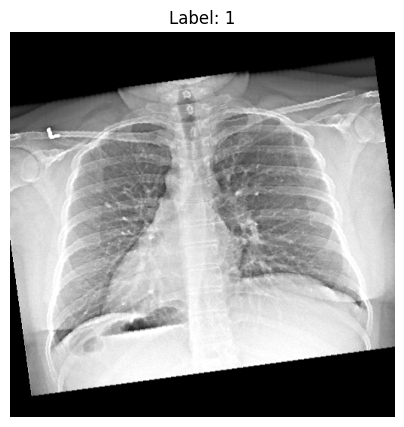

Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: -1.0 1.0
Label: 1.0


In [21]:
train_dataset = CXRClassificationDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=train_transforms 
)

# 170 label 1 / 194 label 0
img, label = train_dataset[170]

plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"Label: {int(label.item())}")
plt.axis("off")
plt.show()

print("Tipus img:", type(img))
print("Shape img:", img.shape)
print("Min / Max img:", img.min().item(), img.max().item())
print("Label:", label.item())

val_dataset = CXRClassificationDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=val_transforms    
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import Node21_Utils as Utils
import Node21_Models as Models
import importlib

importlib.reload(Utils)
importlib.reload(Models)

## Entrenament del Model 1: TinyCXRNet

cpu


Èpoques:  10%|█         | 1/10 [03:33<31:57, 213.02s/it]

[Època 1] Train loss 1.1166 acc 0.513 | Val loss 1.0385 acc 0.685


Èpoques:  20%|██        | 2/10 [06:06<23:44, 178.12s/it]

[Època 2] Train loss 1.0376 acc 0.585 | Val loss 1.0234 acc 0.564


Èpoques:  30%|███       | 3/10 [09:19<21:33, 184.84s/it]

[Època 3] Train loss 1.0159 acc 0.615 | Val loss 1.0104 acc 0.613


Èpoques:  40%|████      | 4/10 [16:16<27:39, 276.62s/it]

[Època 4] Train loss 0.9990 acc 0.636 | Val loss 0.9915 acc 0.749


Èpoques:  50%|█████     | 5/10 [23:03<26:57, 323.53s/it]

[Època 5] Train loss 0.9776 acc 0.654 | Val loss 0.9721 acc 0.699


Èpoques:  60%|██████    | 6/10 [29:51<23:28, 352.18s/it]

[Època 6] Train loss 0.9644 acc 0.655 | Val loss 0.9865 acc 0.771


Èpoques:  70%|███████   | 7/10 [35:37<17:30, 350.07s/it]

[Època 7] Train loss 0.9031 acc 0.706 | Val loss 0.8942 acc 0.766


Èpoques:  80%|████████  | 8/10 [38:11<09:35, 287.67s/it]

[Època 8] Train loss 0.8644 acc 0.716 | Val loss 0.8457 acc 0.782


Èpoques:  90%|█████████ | 9/10 [43:22<04:55, 295.12s/it]

[Època 9] Train loss 0.8203 acc 0.741 | Val loss 0.7475 acc 0.789


Èpoques: 100%|██████████| 10/10 [47:49<00:00, 286.91s/it]

[Època 10] Train loss 0.7074 acc 0.790 | Val loss 0.8067 acc 0.858


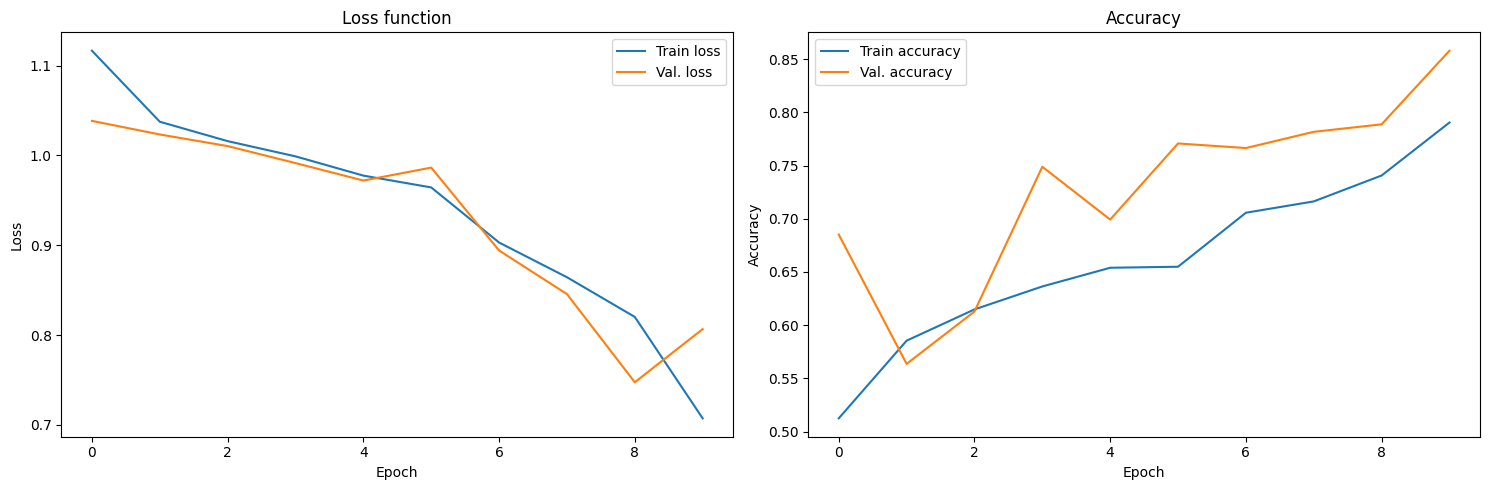

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.TinyCXRNet().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer = Utils.make_optimizer(model, lr=1e-4, weight_decay=1e-4)

history = Utils.fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device,
)

Utils.plot_training_history(history=history)

## Entrenament del Model 2: ResNet18Binary

## Entrenament del Model 3: DenseNet121Binary

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model3 = Models.DenseNet121Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer3 = Utils.make_optimizer_denseNet(model3, lr=1e-5, weight_decay=1e-2)

# Entrenament
print("Entrenant Model 3: DenseNet121...")
history3 = Utils.fit(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer3,
    epochs=5,
    device=device,
)

Utils.plot_training_history(history=history3)
#Utils.plot_confusion_matrix(model3, val_loader, device)

cpu
Entrenant Model 3: DenseNet121...


Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
------------------------------
Pred: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True: [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
------------------------------
Pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
True: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
------------------------------
Pred: [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
True: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
------------------------------
Pred: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

Èpoques:  20%|██        | 1/5 [16:02<1:04:07, 962.00s/it]

------------------------------
[Època 1] Train loss 1.0326 acc 0.705 | Val loss 1.0388 acc 0.378
Pred: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
True: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
------------------------------


Èpoques:  20%|██        | 1/5 [17:00<1:08:01, 1020.30s/it]


KeyboardInterrupt: 

## Entrenament del Model 4: InceptionV3Binary

cpu


Èpoques:  20%|██        | 1/5 [12:37<50:29, 757.49s/it]

[Època 1] Train loss 1.0628 acc 0.549 | Val loss 1.0545 acc 0.766


Èpoques:  40%|████      | 2/5 [24:12<36:01, 720.48s/it]

[Època 2] Train loss 1.0528 acc 0.636 | Val loss 1.0372 acc 0.600


Èpoques:  60%|██████    | 3/5 [35:45<23:36, 708.28s/it]

[Època 3] Train loss 1.0245 acc 0.663 | Val loss 1.0153 acc 0.661


Èpoques:  80%|████████  | 4/5 [47:03<11:36, 696.25s/it]

[Època 4] Train loss 0.9893 acc 0.704 | Val loss 0.9753 acc 0.672


Èpoques: 100%|██████████| 5/5 [59:15<00:00, 711.17s/it]

[Època 5] Train loss 0.9199 acc 0.755 | Val loss 0.8948 acc 0.715


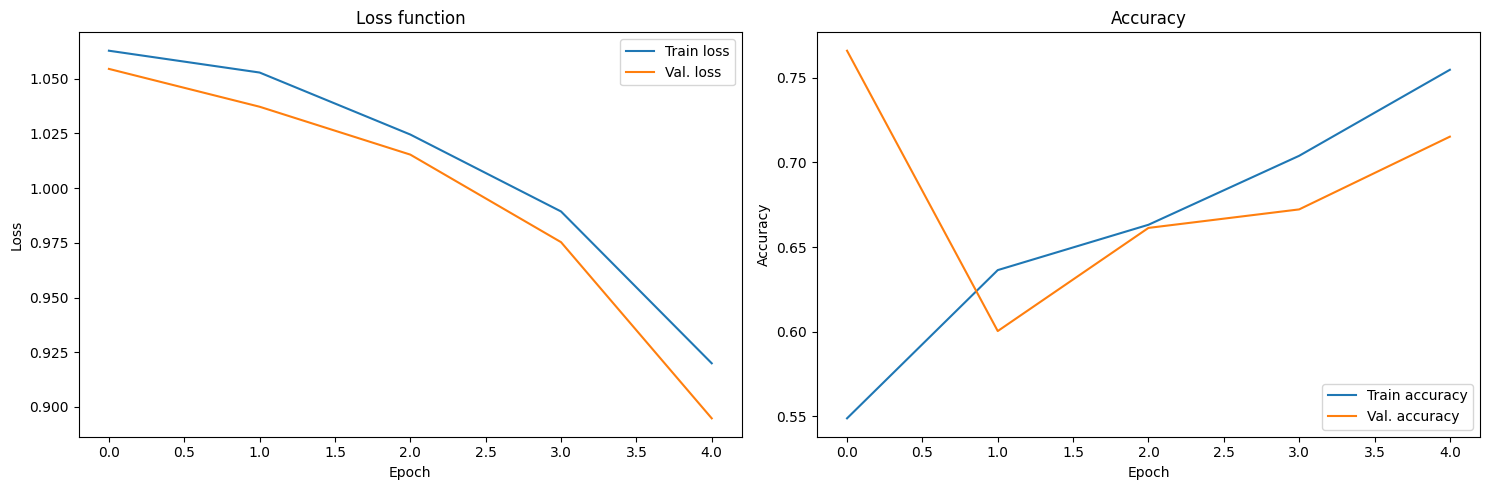

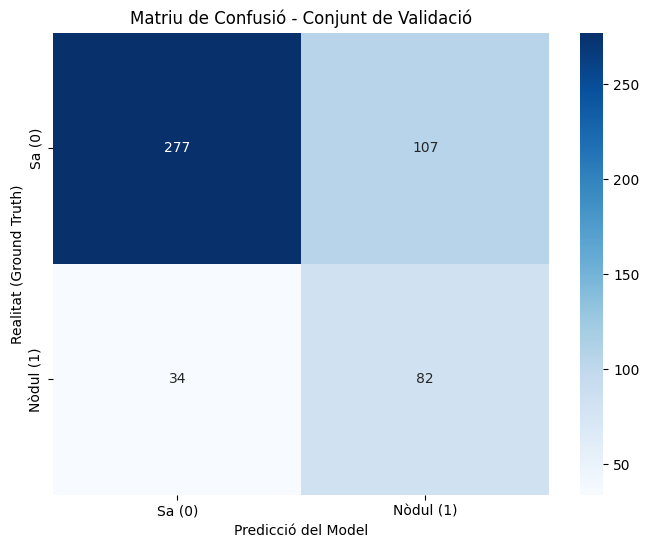


--- Informe de Classificació ---
              precision    recall  f1-score   support

          Sa       0.89      0.72      0.80       384
       Nòdul       0.43      0.71      0.54       116

    accuracy                           0.72       500
   macro avg       0.66      0.71      0.67       500
weighted avg       0.78      0.72      0.74       500



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model4 = Models.InceptionV3Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer4 = Utils.make_optimizer(model4, lr=1e-5, weight_decay=5e-2)

# Entrenament
history4 = Utils.fit(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer4,
    epochs=5,
    device=device
)

Utils.plot_training_history(history4)
Utils.plot_confusion_matrix(model4, val_loader, device)

## Classificació

### Model 1

#### Capes de `TinyCXRNet` per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: xarxa convolucional lleugera que extreu patrons visuals rellevants de la imatge i retorna un únic **logit** que es transforma en probabilitat mitjançant una funció sigmoide.

Les **capes convolucionals 3×3** (`nn.Conv2d`) són les encarregades d’extreure patrons locals de la imatge, com vores, textures i petites variacions d’intensitat, que són especialment rellevants en radiografies pulmonars.

- L’ús de kernels **3×3** permet capturar context local amb pocs paràmetres, i el `padding=1` manté la mida espacial de la imatge després de la convolució, evitant pèrdua d’informació als marges.

A mesura que la **resolució espacial** es redueix, augmenta el nombre de canals (16 → 32 → 64 → 128) per mantenir la capacitat representacional del model.

- Els primers canals capturen patrons simples.
- Els canals més profunds combinen aquests patrons per descriure estructures més complexes i regions potencialment anòmales.


La **Batch Normalization** (`nn.BatchNorm2d`) s’utilitza per estabilitzar l’entrenament i reduir la variabilitat interna de les activacions. En imatges mèdiques, on poden existir diferències d’adquisició i contrast, aquesta capa ajuda a fer el model més robust i accelera la convergència durant l’entrenament.


El **MaxPool (`nn.MaxPool2d(2)`)** redueix la resolució espacial i el cost computacional, alhora que augmenta el camp receptiu de les capes profundes.

En aquest model s’apliquen tres operacions de MaxPool (512→256→128→64). No s’aplica un quart pooling final per evitar perdre massa detall espacial, ja que els nòduls poden ser estructures relativament petites.

Les **capes** `AdaptiveAvgPool2d` i `AdaptiveMaxPool2d` transformen els mapes de característiques finals a una mida fixa **4×4**, independentment de la resolució d’entrada, fent el model més flexible.

- **AdaptiveAvgPool2d** aporta informació global i context general de la imatge.
- **AdaptiveMaxPool2d** preserva activacions locals fortes, útils per detectar lesions petites.

La concatenació d’ambdues sortides combina context global i informació local en una única representació més rica.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització per reduir el risc de sobreajust. És especialment útil en contextos mèdics, on els conjunts de dades solen ser limitats o desbalancejats, ja que obliga el model a no dependre excessivament d’un subconjunt concret de neurones.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària.

### Model 2

#### Capes de `ResNet18Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en **transfer learning**, que reutilitza una xarxa profunda preentrenada (`ResNet18`) per extreure característiques visuals robustes, adaptant-la posteriorment al problema específic de detecció de nòduls mitjançant un capçal binari amb un únic **logit**.


Aquest model utilitza **ResNet18 preentrenada en ImageNet** com a *backbone*. El transfer learning permet aprofitar característiques visuals apreses prèviament sobre un conjunt molt gran d’imatges, com detectors de vores, textures i formes generals, que també són útils en radiografies mèdiques.

L’avantatge principal d’aquest enfocament és que el model **no parteix de zero**, fet especialment important en contextos mèdics on la quantitat de dades etiquetades sol ser limitada. Això acostuma a millorar la capacitat de generalització i accelera la convergència durant l’entrenament.


La primera capa convolucional de ResNet18 s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats, ajustant-los al domini CXR de manera coherent.


El *backbone* ResNet18 està format per **blocs residuals**, que introdueixen connexions directes entre capes. Aquestes connexions residuals faciliten l’entrenament de xarxes profundes, eviten problemes de degradació del gradient i permeten aprendre representacions més estables i riques que en una CNN simple.

Gràcies a aquesta estructura, el model pot capturar tant **patrons locals** com **context global**, aspecte clau en radiografies pulmonars, on la presència d’un nòdul pot dependre tant d’una petita regió local com del context anatòmic que l’envolta.


El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:

- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per ResNet18 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.


El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.


L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.


En conjunt, aquest segon model permet comparar un enfocament **des de zero (Model 1)** amb un enfocament basat en **transfer learning (Model 2)**, analitzant l’impacte de reutilitzar coneixement previ en la detecció automàtica de nòduls en radiografies de tòrax.


### Model 3:

#### Capes de `DenseNet121Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **DenseNet121** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar filtres visuals complexos ja optimitzats, adaptant la xarxa a la naturalesa específica de les imatges mèdiques mitjançant una reconfiguració de la seva topologia d'entrada i del seu capçal final.

Aquest model es diferencia de les arquitectures residuals convencionals pel seu ús de **blocs densos** (Dense Blocks). En aquestes estructures, cada capa rep com a entrada els mapes de característiques de totes les capes anteriors i passa els seus propis mapes a totes les següents. 

L'avantatge principal d'aquesta **connectivitat extrema** per a la detecció de nòduls és:

- Millora el **flux de gradients** i d'informació a través de tota la xarxa, reduint el risc de desaparició del gradient.
- Fomenta la **reutilització de característiques** (*feature reuse*), permetent que detalls fins de la textura del nòdul es mantinguin disponibles per a les capes més profundes.
- Produeix un model amb **menys paràmetres** que una ResNet equivalent, cosa que ajuda a mitigar el **sobreajust (overfitting)** en el dataset Node21.

La primera capa convolucional de la DenseNet s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per DenseNet121 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest tercer model permet comparar diferents arquitectures de transfer learning (ResNet vs DenseNet) i avaluar quin enfocament és més efectiu per a la detecció automàtica de nòduls en radiografies de tòrax.

### Model 4

#### Capes de `InceptionV3Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 299, 299]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **InceptionV3** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar la seva capacitat de processament multi-escala, adaptant la xarxa per detectar nòduls de mides variables mitjançant una reconfiguració de la mida d'entrada i del capçal final.



A diferència de les arquitectures lineals o residuals, la **InceptionV3** utilitza mòduls que executen diverses operacions convolucionals en paral·lel ($1\times1, 3\times3, 5\times5$).

L'avantatge principal d'aquest enfocament **multi-escala** per a la detecció de nòduls és:

- Permet capturar **característiques a diferents resolucions** simultàniament, essent ideal per a nòduls que poden presentar-se amb diàmetres molt dispars.
- L'ús de convolucions factoritzades (com $1\times7$ i $7\times1$) ajuda a reduir el cost computacional i el sobreajust mentre s'aprofundeix en la representació del teixit pulmonar.
- El model inclou **classificadors auxiliars** (durant l'entrenament) que ajuden a combatre la desaparició del gradient i milloren la convergència en xarxes tan profundes.

La primera capa convolucional s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone
- una activació ReLU que introdueix no linealitat
- una capa de Dropout per reduir el sobreajust
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per InceptionV3 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest quart model permet explorar com una arquitectura profundament multi-escala com InceptionV3 pot millorar la detecció automàtica de nòduls en radiografies de tòrax, especialment quan aquests poden variar significativament en mida i aparença.

## Detecció

In [14]:
import os
import pandas as pd
from torchvision import transforms

# --- CONFIGURACIÓ ---
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "./data/cxr_images/proccessed_data/metadata.csv"

N_IMAGES = 2000  
VAL_RATIO = 0.25  
IMG_SIZE = 512
BATCH_SIZE = 16

In [15]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Node21DetectionDataset(Dataset):
    def __init__(self, img_ids, annotations_df, img_dir, img_size=512, transform=None):
        self.img_ids = img_ids
        self.df = annotations_df
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        # 1. Càrrega del fitxer .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img_sitk = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img_sitk)
        
        # Gestió de dimensions (per si sitk retorna [1, H, W])
        if len(arr.shape) == 3: 
            arr = arr[0]
        
        # 2. Preprocessament (Percentils i Normalització)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)
    
        # 3. Redimensionat i Càlcul d'Escala
        original_h, original_w = arr.shape
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))
        
        scale_x = self.img_size / original_w
        scale_y = self.img_size / original_h
    
        # 4. Extracció i Reescalat de Bounding Boxes
        img_anns = self.df[self.df['image_id'] == img_id]
        boxes = []
        labels = []
        
        for _, row in img_anns.iterrows():
            if row['label'] == 1:
                # Convertim x, y, w, h a [xmin, ymin, xmax, ymax] i escalem
                xmin = row['x'] * scale_x
                ymin = row['y'] * scale_y
                xmax = (row['x'] + row['width']) * scale_x
                ymax = (row['y'] + row['height']) * scale_y
                
                # Validem que la caixa tingui àrea positiva
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(1) # 1 = Nòdul
    
        # 5. Creació del Diccionari Target (format torchvision)
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            # Imatges sanes: boxes buides de forma [0, 4]
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
    
        target = {"boxes": boxes, "labels": labels}
    
        img_tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255.0
        img_tensor = img_tensor.repeat(3, 1, 1) # [1, 512, 512] -> [3, 512, 512]
    
        return img_tensor, target

In [16]:
# 1. Preparar el DataFrame
df_meta = pd.read_csv(ANNOTATION_FILE)
df_meta['image_id'] = df_meta['img_name'].str.replace('.mha', '')

# 2. Split de dades
unique_ids = df_meta['image_id'].unique()
if len(unique_ids) > N_IMAGES:
    unique_ids = unique_ids[:N_IMAGES]

train_size = int(len(unique_ids) * (1 - VAL_RATIO))
train_ids = unique_ids[:train_size]
val_ids = unique_ids[train_size:]

# 3. Collate i Transformacions
def collate_fn(batch):
    return tuple(zip(*batch))

transform = transforms.Compose([transforms.ToTensor()])

# 4. Instanciar Loaders
train_dataset = Node21DetectionDataset(train_ids, df_meta, IMG_DIR, transform=transform)
val_dataset = Node21DetectionDataset(val_ids, df_meta, IMG_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Dataset de detecció configurat: {len(train_ids)} train / {len(val_ids)} val.")


Dataset de detecció configurat: 1500 train / 500 val.


In [17]:
img, target = train_dataset[567]
print(f"Exemple - Boxes: {target['boxes']}")

Exemple - Boxes: tensor([[174.0000, 171.0000, 224.5000, 225.5000],
        [133.0000, 321.5000, 171.0000, 364.0000],
        [308.0000, 357.5000, 333.0000, 387.0000]])


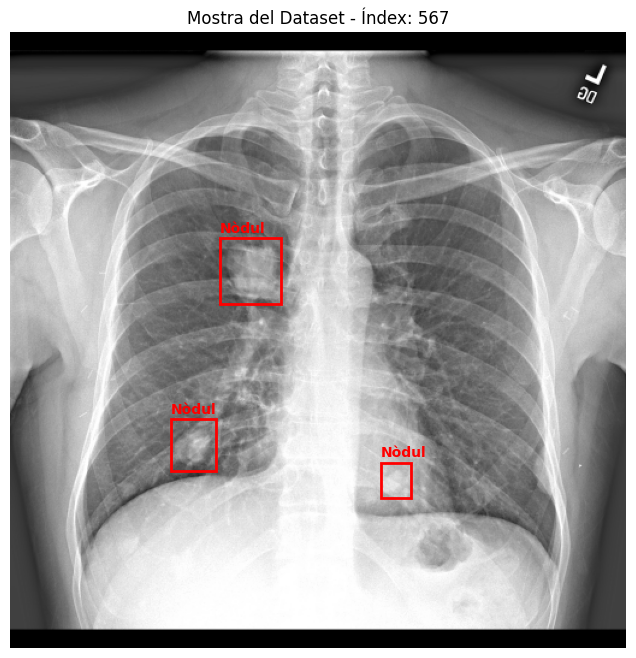

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_sample(dataset, idx=0):
    # 1. Obtenir la imatge i el target del dataset
    img_tensor, target = dataset[idx]
    
    # 2. Convertir el tensor de nou a format imatge per a matplotlib
    # De [3, 512, 512] a [512, 512, 3]
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # Crear la figura
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    # 3. Dibuixar cada caixa
    boxes = target['boxes']
    for box in boxes:
        # Les coordenades estan en [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        # Crear el rectangle (coordenada x, y, amplada, alcada)
        rect = patches.Rectangle(
            (xmin, ymin), width, height, 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin-5, 'Nòdul', color='red', fontweight='bold')
    
    plt.title(f"Mostra del Dataset - Índex: {idx}")
    plt.axis('off')
    plt.show()

# Prova-ho amb el primer element que tingui un nòdul
# Pots anar canviant l'índex (0, 1, 2...) fins a veure un nòdul
show_sample(train_dataset, idx=567)

In [36]:
import Node21_Utils as Utils
import Node21_Models as Models
import importlib

importlib.reload(Utils)
importlib.reload(Models)

<module 'Node21_Models' from 'C:\\Users\\pauan\\Documentos\\Universidad\\Quart\\1er Quatrimestre\\Aprenentatge Automàtic\\Node21_AA_2025-26\\Node21_Models.py'>

## Entrenament del Model 1 de Detecció: RetinaNetDetector


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.RetinaNetDetector().to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = Utils.make_optimizer_detection(model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

history = Utils.fit_det(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    epochs=10,
    device=device
)

# Visualitzem la pèrdua
Utils.plot_detection_history(history)

cpu


Èpoques:   0%|          | 0/10 [05:57<?, ?it/s]


KeyboardInterrupt: 

### Model 1

#### Capes de `RetinaNetDetector` per a detecció de nòduls en CXR

## Innovació